# Применение моделей машинного обучения для сегментации клиентов интернет-магазина "В один клик" и повышения их покупательской активности

**Описание проекта**

Интернет-магазин "В один клик" - успешный и современный ритейлер, который занимается продажей различных категорий товаров.


В прошлом периоде в отчете интернет-магазина наметилась негативная динамика: судя по показателям активность клиентов стала снижаться. В силу насыщенности рынка привлекать новых клиентов менее эффективно, чем удерживать лояльность постоянных покупателей.


Нам предстоит выступить в роли стажера в отделе цифровых технологий интернет-магазина и вместе с командой разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


**Описание данных**

Рабочие данные находятся в нескольких таблицах.

`market_file.csv` - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.


`market_money.csv` - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.


`market_time.csv` - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.


`money.csv` - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.


**Цель проекта**   
Построить модель машинного обучения, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

**Задачи проекта:**
1. Промаркировать уровень покупательской активности постоянных покупателей. 
    В компании принято выделять два уровня активности: 
    + «снизилась», если клиент стал покупать меньше товаров,
    + «прежний уровень».
2. Собрать данные по клиентам (входные данные модели) по следующим группам:
    - коммуникация с клиентом, 
    - продуктовое поведение, 
    - поведение на сайте,
    - финансовое поведение.
3.  Используя данные по клиентам (входные данные модели) и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения. Данные о прибыльности клиентов предоставляются финансовым департаментом и заключают в себе информацию о том, какой доход каждый покупатель приносил компании за последние три месяца.
    

**Инструкция по выполнению проекта**
    
    Ход решения исследовательской задачи сформулирован руководителем отдела.

Решать задачу нужно в два этапа:
    
1) Разработать модель, которая предскажет вероятность снижения покупательской активности.
    
2) Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность. Для этого необходимо использовать данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся). По желанию можно проанализировать больше одного сегмента.
    
Ниже несколько примеров сегментов, но вы также можете выделить свой:
- Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
- Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
- Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».
- Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

In [1]:
# код ревьюера
! pip install shap
! pip install -U scikit-learn
! pip install phik

     |████████████████████████████████| 539 kB 199 kB/s eta 0:00:01
     |████████████████████████████████| 13.4 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 94.9 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 686 kB 2.0 MB/s eta 0:00:01


In [2]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# загружаем класс для разделения выборок на train и test 
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# устанавливаем и импортируем библиотеку phik
import phik

# загружаем функцию для построения матрицы корреляции phik
from phik.report import plot_correlation_matrix

# загружаем функцию для проверки VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# устанавливаем и импортируем библиотеку shap
import shap

# задаем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

Загрузим данные из файлов csv с использованием соответствующих разделителей.

In [3]:
# читаем данные из датасетов
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [4]:
# посмотрим на информацию о данных по поведению покупателей на сайте, о коммуникациях с покупателями и продуктовом поведении
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [5]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


В датафрейме содержится следующая информация о покупателях:

`id` — номер покупателя в корпоративной базе данных.

`Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

`Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».

`Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

`Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

`Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.

`Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

`Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

`Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.

`Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

`Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.

`Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.

`Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Форматы данных соответствуют содержанию признаков. В данных нет пропусков.

Некоторые названия переменных отличаются. Нужно привести их к одному виду.


В наименованиях категорий некоторых переменных есть ошибки. В частности, в переменной `Тип сервиса`. Необходимо проверить наличие таких ошибок и в других переменных и избавиться от них при необходимости.

In [6]:
market_file.select_dtypes(include='object').columns.tolist()

['Покупательская активность',
 'Тип сервиса',
 'Разрешить сообщать',
 'Популярная_категория']

In [7]:
# выведем информацию о выручке с покупателей 
market_money.info()        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
# первые пять наблюдений датасета о выручке
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Этот датасет содержит следующие поля:

`id` — номер покупателя в корпоративной базе данных.

`Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

`Выручка` — сумма выручки за период.

В этом наборе мы видим данные о выручке интернет-магазина за три месяца. Для каждого пользователя втрое больше строк, чем в первом датасете.

Никаких явных ошибок в данных нет.

In [9]:
# выведем информацию о датафрейме с данными о времени активности покупателей на сайте (в минутах)
market_time.info()         

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
# посмотрим на первые пять наблюдений
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


В наборе данных три переменных:

`id` — номер покупателя в корпоративной базе данных.

`Период` — название периода, во время которого зафиксировано общее время.

`минут` — значение времени, проведённого на сайте, в минутах.

В этом наборе представлена информация по каждому пользователю интернет-магазина за два периода, поэтому строк вдвое больше, чем в первом датасете.

Необходимо исправить ошибки в категории "предыдцщий_месяц" столбца `Период` и изменить название переменной со временем, проведенным на сайте пользователями.

In [11]:
# посмотрим на информацию о данных по среднемесячной прибыли магазина с покупателей за последние 3 месяца
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [12]:
# выведем первые пять строк датасета
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Здесь хранятся всего две переменные:

`id` — номер покупателя в корпоративной базе данных.

`Прибыль` — значение прибыли.

С данными все в порядке. Можно переходить к предобработке.

На этапе загрузки данных мы выявили следующее:
1. Содержание наборов с данными соответсвует описанию.
2. Нужно привести к одному виду названия переменных в `market_file`. В этом же датасете необходимо проверить наличие ошибок в названиях категорий и исправить их.
3. В датафрейме `market_time` мы должны исправить ошибки в категории "предыдцщий_месяц" столбца `Период` и изменить название переменной со временем, проведенным на сайте пользователями.

Переходим к этапу преобработки данных.

## Предобработка данных

Выполним необходимые действия по предобработке данных, которые были запланированы на предыдущем этапе.

Для начала выведем информацию о названиях переменных в наборе данных `market_file`.

In [13]:
# выведем список названий столбцов датафрейма
market_file.columns.tolist()

['id',
 'Покупательская активность',
 'Тип сервиса',
 'Разрешить сообщать',
 'Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Популярная_категория',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит']

Будем использовать исходные названия признаков в кириллице для построения модели.

В названиях прослеживается наличие наименований, у которых разделителем слов служит пробел. У большинства использовано нижнее подчеркивание. Приведем все названия к одному виду.

In [14]:
# при помощи rename заменим старые названия столбцов на новые
market_file = market_file.rename(columns={'Покупательская активность':'Покупательская_активность',
                                          'Тип сервиса': 'Тип_сервиса',
                                          'Разрешить сообщать':'Разрешить_сообщать'})

In [15]:
# выведем наименования переменных еще раз
market_file.columns.tolist()

['id',
 'Покупательская_активность',
 'Тип_сервиса',
 'Разрешить_сообщать',
 'Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Популярная_категория',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит']

Проверим ошибки в категориях данного датафрейма.

In [16]:
# сохраним в отдельную переменную список категориальных показателей датафрейма
cat_col_market_file = market_file.select_dtypes(include='object').columns.tolist()

In [17]:
# для каждого показателя выведем уникальные категории
for column in cat_col_market_file:
    print(column)
    print(market_file[column].unique(), '\n')

Покупательская_активность
['Снизилась' 'Прежний уровень'] 

Тип_сервиса
['премиум' 'стандартт' 'стандарт'] 

Разрешить_сообщать
['да' 'нет'] 

Популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника'] 



Нам удалось выявить ошибки в данных. Исправим их.

In [18]:
# исправим ошибки в данных заменой
market_file.loc[market_file['Тип_сервиса']=='стандартт','Тип_сервиса'] = 'стандарт'
market_file.loc[market_file['Популярная_категория']=='Косметика и аксесуары','Популярная_категория'] = 'Косметика и аксесcуары'

# перепишем наименования категорий с прописной буквы 
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].str.capitalize()
market_file['Разрешить_сообщать'] = market_file['Разрешить_сообщать'].str.capitalize()

# приведем наименования категорий к единому виду - добавим вместо пробела между словами нижнее подчеркивание
market_file['Популярная_категория'] = market_file['Популярная_категория'].str.replace(' ','_')
market_file['Покупательская_активность'] = market_file['Покупательская_активность'].str.replace(' ','_')

In [19]:
# снова выведем уникальные категории и проверим трансформации
for column in cat_col_market_file:
    print(column)
    print(market_file[column].unique(), '\n')

Покупательская_активность
['Снизилась' 'Прежний_уровень'] 

Тип_сервиса
['Премиум' 'Стандарт'] 

Разрешить_сообщать
['Да' 'Нет'] 

Популярная_категория
['Товары_для_детей' 'Домашний_текстиль' 'Косметика_и_аксесcуары'
 'Техника_для_красоты_и_здоровья' 'Кухонная_посуда'
 'Мелкая_бытовая_техника_и_электроника'] 



Исправили наименования столбцов и названия категорий в датафрейме `market_file`.

Далее перейдем к устранению ошибок в данных датафрейма `market_time`.

In [20]:
# выведем список названий столбцов датафрейма
market_time.columns.tolist()

['id', 'Период', 'минут']

Переименуем столбец `минут` во `Время_на_сайте`.

In [21]:
# при помощи rename заменим старые названия столбцов на новые
market_time = market_time.rename(columns={'минут':'Время_на_сайте'})

Далее мы должны исправить ошибки в категориях столбца `Период`.

In [22]:
# выведем уникальные значения столбца
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Отредактируем наименования категорий.

In [23]:
# исправим ошибки в данных заменой
market_time.loc[market_time['Период']=='предыдцщий_месяц','Период'] = 'предыдущий_месяц'

# перепишем наименования категорий с прописной буквы 
market_time['Период'] = market_time['Период'].str.capitalize()

In [24]:
# снова выведем на экран уникальные значения столбца
market_time['Период'].unique()

array(['Текущий_месяц', 'Предыдущий_месяц'], dtype=object)

Завершим этап предобработки проверкой категорий в столбце `Период` в наборе данных `market_money`.

In [25]:
# выведем на экран уникальные значения переменной
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Капитализируем названия периодов, как для предыдущего набора данных. 

In [26]:
# перепишем наименования категорий с прописной буквы 
market_money['Период'] = market_money['Период'].str.capitalize()

In [27]:
# проверим результат
market_money['Период'].unique()

array(['Препредыдущий_месяц', 'Текущий_месяц', 'Предыдущий_месяц'],
      dtype=object)

Итак, мы завершили этап предобработки данных. Устранили ошибки в названиях столбцов и наименованиях категорий.
Перейдем к исследовательскому анализу данных.

## Исследовательский анализ данных

Проведем исследовательский анализ данных из каждой таблицы. Начнем с `market_file`.

### Исследовательский анализ данных набора `market_file`

Для количественных переменных выведем таблицу с описательной статистикой, изобразим диаграммы "ящик с усами" и гистограммы распределения. Для каждого категориального признака выведем круговую диаграмму с долями соответсвующих категорий.

In [28]:
# строим таблицу с описательной статистикой
market_file.drop(columns='id').describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Маркет_актив_6_мес,1300.0,4.25,1.01,0.9,3.70,4.20,4.9,6.60
Маркет_актив_тек_мес,1300.0,4.01,0.70,3.0,4.00,4.00,4.0,5.00
Длительность,1300.0,601.90,249.86,110.0,405.50,606.00,806.0,1079.00
Акционные_покупки,1300.0,0.32,0.25,0.0,0.17,0.24,0.3,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.27,1.36,1.0,2.00,3.00,4.0,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.84,1.97,0.0,1.00,3.00,4.0,10.00
Ошибка_сервиса,1300.0,4.19,1.96,0.0,3.00,4.00,6.0,9.00
Страниц_за_визит,1300.0,8.18,3.98,1.0,5.00,8.00,11.0,20.00


Напрашиваются следующие выводы о переменных набора данных:

`Маркет_актив_6_мес`: среднее число различных видов взаимодействия с клиентом за последние полгода составило около 4,2. Типичная картина такая - каждый клиент минимум один раз в среднем за последние шесть месяцев контактировал с компанией через один из каналов коммуникации.

`Маркет_актив_тек_мес`: от 3 до 5 маркетинговых коммуникаций произошло у каждого клиента в текущем месяце.

`Длительность`: самый первый клиент интернет-магазина зарегистрировался на сайте около 3 лет назад. Половина всех клиентов прошли регистрацию на сайте от 405 до 806 дней назад. Последний клиент в выборке зарегистрировался 110 дней назад. То есть в наборе данных нет клиентов, кто бы зарегистрировался в последние 3,5 месяца.

`Акционные_покупки`: примерно четверть от всех покупок - столько составляет среднемесячная доля покупок по акции от общего числа покупок каждого пользователя за последние 6 месяцев. Однако есть и такие пользователи, которые либо совсем не совершали подобных приобретений в указанный срок, либо покупали товары только из акционного перечня.

`Средний_просмотр_категорий_за_визит`: за один визит за последние полгода клиенты просматривают в среднем около трех категорий товаров. Самое максимальное значение этого показателя - шесть, а минимальное - 1.

`Неоплаченные_продукты_штук_квартал`: пользователи интересуются, но не покупают примерно по три товара в среднем за последние 3 месяца. У четверти пользователей либо вообще нет таких товаров в корзине, либо всего один, а максимальное число неоплаченных товаров у одного пользователя - 10.

`Ошибка_сервиса`: каждый пользователь сталкивался с достаточно большим числом сбоев при работе с сервисом. У 75% пользователей из выборки таких случаев насчитывалось более трех. 

`Страниц_за_визит`: типичной величиной среднего количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, можно считать значение 8. Минимально пользователи просматривали всего одну страницу с товарами, а максимально - 20 в среднем за рассматриваемый период.


Далее посмотрим на графическое изображение распределений перечисленных количественных переменных датасета.

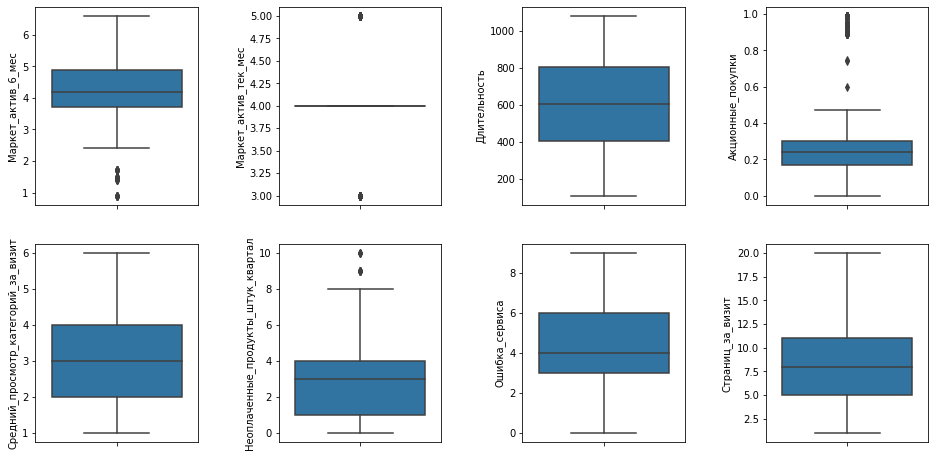

In [29]:
# запишем названия столбцов с количественными признаками в отдельную переменную 
columns_to_boxplot = market_file.drop('id',axis=1).select_dtypes(exclude='object').columns

# построим диаграмму "ящик с усами"
fig_box = plt.figure(figsize=(16,8)) # задаем параметры графика
subplt_box = 1 # номер начального axes

# задаем в цикле построение диаграммы для каждого количественного признака
for column in columns_to_boxplot:
    ax_box = fig_box.add_subplot(2, 4, subplt_box)
    sns.boxplot(data=market_file, y=column)
    plt.subplots_adjust(wspace=0.5) 
    subplt_box+=1
plt.show()

Выделим следующие особенности, которые можно заметить в результате визуального анализа диаграмм:

На пользователей интернет-магазина из представленной выборки приходилось свыше двух маркетинговых коммуникаций в среднем за последние полгода, а в текущем месяце каждый пользователь принял участие в 3-5 таких взаимодействий.

Менее половины акционных покупок в расходах - характерная картина для пользователей сервиса.

Большинство пользователей оставляет до 8 товаров неоплаченными в корзине за последние 3 месяца.

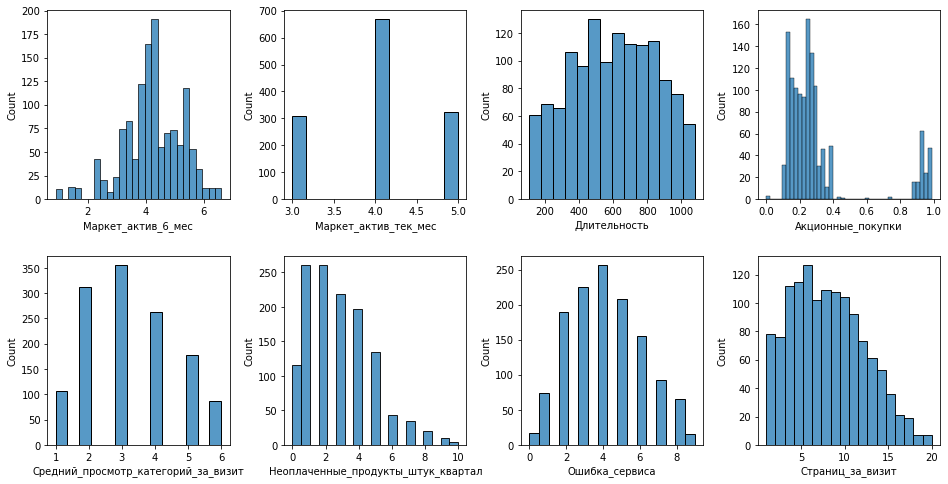

In [30]:
# запишем названия столбцов с количественными признаками в отдельную переменную 
columns_to_histplot = market_file.drop('id',axis=1).select_dtypes(exclude='object').columns

# построим гистограмму
fig_hist = plt.figure(figsize=(16,8)) # задаем параметры графика
subplt_hist = 1 # номер начального axes

# задаем в цикле построение гистограммы для каждого количественного признака
for column in columns_to_histplot:
    ax_hist = fig_hist.add_subplot(2, 4, subplt_hist)
    sns.histplot(data=market_file, x=column)
    plt.subplots_adjust(wspace=0.3, hspace=0.3) 
    subplt_hist+=1
plt.show()

По итогам анализа гистограмм можно сформулировать следующие наблюдения:

Центр распределения среднемесячного значения маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев (`Маркет_актив_6_мес`), соотносится с модальным количеством маркетинговых коммуникаций в текущем месяце (`Маркет_актив_тек_мес`).

Основная когорта пользователей - это те кто зарегистрировался на сервисе год назад, что подтверждает гипотезу о насыщении рынка, так как новых клиентов интернет-магазина существенно меньше.


В выборке присутствует существенный сегмент тех клиентов, которые покупали практически только акционные товары (`Акционные_покупки`).

Распределение показателей просмотра категорий за визит (`Средний_просмотр_категорий_за_визит`), как и просмотра страниц за визит (`Страниц_за_визит`) похоже на логарифмически нормальное, когда пик наблюдений модального интервала смещен влево. 

У показателя ошибок сервиса, наборот, распределение близко к нормальному, то есть типичным для большинства клиентов из выборки является 3-5 ошибок.

Следующим нашим шагом будет анализ категориальных признаков.

Для них построим круговые диаграммы и посмотрим на соотношение соответствующих категорий в выборке. 

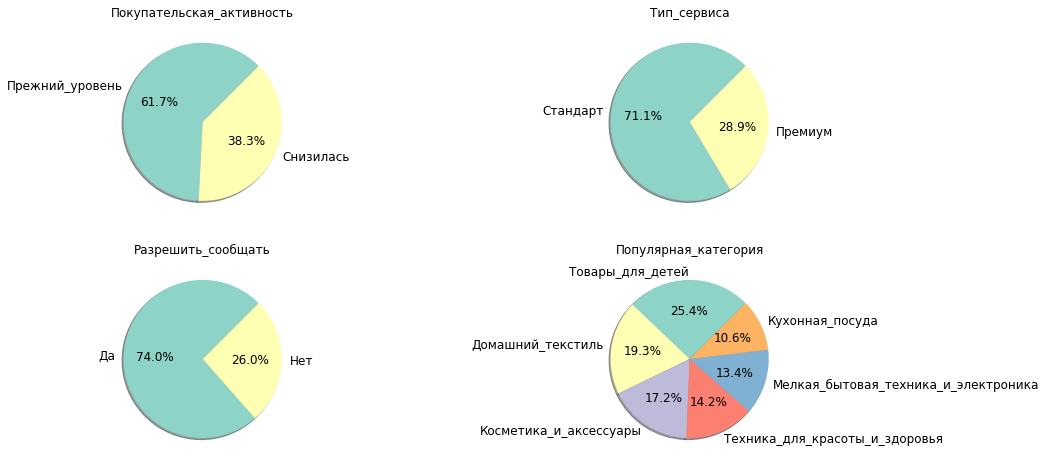

In [31]:
# запишем названия столбцов с категориальными признаками в отдельную переменную 
columns_to_pieplot = market_file.drop('id',axis=1).select_dtypes(include='object').columns

# построим круговую диаграмму
fig_pie = plt.figure(figsize=(16,8))
subplt_pie = 1

# задаем в цикле построение круговой диаграммы для каждого категориального признака
for column in columns_to_pieplot:
    ax_pie = fig_pie.add_subplot(2, 2, subplt_pie)
    market_file[column].value_counts().plot.pie(legend=False, 
                                                autopct='%1.1f%%', 
                                                shadow=True, 
                                                startangle=45, 
                                                ylabel='', 
                                                textprops={'fontsize': 12},
                                                colors=sns.color_palette('Set3'))
    plt.title(column)
    subplt_pie+=1
plt.show()

Семь из десяти клиентов интернет-магазина использовали стандартный функционал сервиса.

Вместе с этим примерно такое же число клиентов находится в постоянном контакте с сервисом, дав согласие на получение дополнительных предложений.  

Самые популярные категории товаров в магазине - товары для детей, домашний текстиль и косметика с аксессуары. На них приходится около 60% всех реализованных товаров за последние 6 месяцев.

Что же касается целевого признака, то снижение покупательской активности зафиксировано менее чем у половины пользователей.

Продолжим анализ и перейдем к следующим наборам данных.

### Исследовательский анализ данных набора `market_time`

В этом наборе содержится информация только о времени, проведённом на сайте, в минутах.

Выведем описательную статистику и построим диаграмму "ящик с усами" и гистограмму распределения для этой переменной, но будем учитывать, что информация в наборе представлена за два периода.

||||||||||||||||||||    Предыдущий_месяц     |||||||||||||||||||| 

                 count   mean   std  min   25%   50%   75%   max
Время_на_сайте  1300.0  13.47  3.93  5.0  11.0  13.0  17.0  23.0


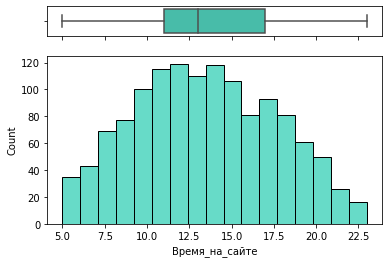



||||||||||||||||||||      Текущий_месяц      |||||||||||||||||||| 

                 count  mean   std  min   25%   50%   75%   max
Время_на_сайте  1300.0  13.2  4.22  4.0  10.0  13.0  16.0  23.0


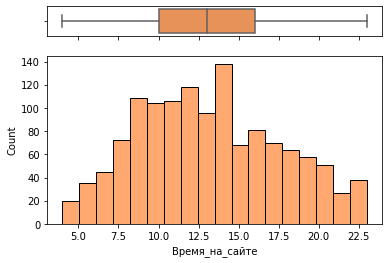

In [32]:
# сформируем переменные с цветами и периодами
palette=["#34D0B6", "#FF8D40"]
periods=['Предыдущий_месяц', 'Текущий_месяц']


# через цикл выведем таблицу с описательной статистикой, построим на одном графике гистограмму и боксплот
for period,color in zip(periods,palette):

    # выведем название периода на экран
    print(f"||||||||||||||||||||{period:^25}|||||||||||||||||||| \n")

    # выведем описательную статистику
    print(market_time
          .loc[market_time['Период']==period]
          .drop(columns='id')
          .describe()
          .round(2)
          .T)

    # формируем поле с двумя графиками
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # назначаем каждой оси соответствующий график
    sns.boxplot(data=market_time.loc[market_time['Период']==period], 
                x='Время_на_сайте',
                orient='h',
                ax=ax_box,
                color=color)
    sns.histplot(data=market_time.loc[market_time['Период']==period],
                 x='Время_на_сайте',
                 ax=ax_hist,
                 color=color)

    # уберем название оси X на боксплоте и выведем на экран результат
    ax_box.set(xlabel='')
    plt.show()
    
    # добавим пустую строку
    print('\n')


Медианное значение времени на сайте не изменилось в текущем месяце по сравнению с предыдущим. Если судить по описательной статистике, то распределение пользователей по этому признаку за два рассматриваемых месяца схожи. 
За исключением некоторых изменений в форме и смещении распределения, это подтверждают и графики.

В среднем пользователи проводили в текущем и предыдущем месяце около 13 минут на сайте. Максимальные значения доходят до 23 минут.

Продолжим анализировать наборы данных и перейдем к третьему из них.

### Исследовательский анализ данных набора `market_money`

В этом наборе данных так же содержится только один признак - Выручка. Проанализируем описательную статистику и распределение по аналогии с предыдущим датасетом. 

||||||||||||||||||||   Препредыдущий_месяц   |||||||||||||||||||| 

          count     mean     std  min     25%     50%     75%     max
Выручка  1300.0  4825.21  405.98  0.0  4583.0  4809.0  5053.5  5663.0


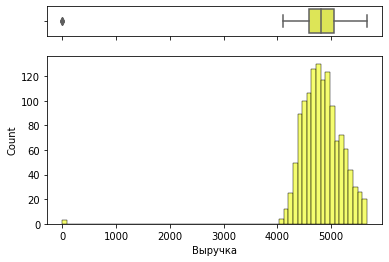



||||||||||||||||||||    Предыдущий_месяц     |||||||||||||||||||| 

          count     mean    std  min      25%     50%      75%     max
Выручка  1300.0  4936.92  739.6  0.0  4496.75  5005.0  5405.62  6869.5


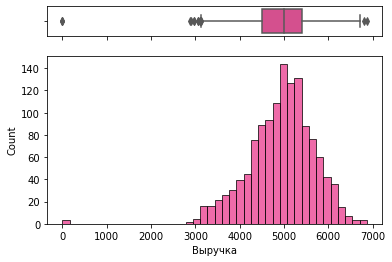



||||||||||||||||||||      Текущий_месяц      |||||||||||||||||||| 

          count     mean      std     min      25%      50%      75%       max
Выручка  1300.0  5314.96  2939.71  2758.7  4706.05  5179.95  5761.72  106862.2


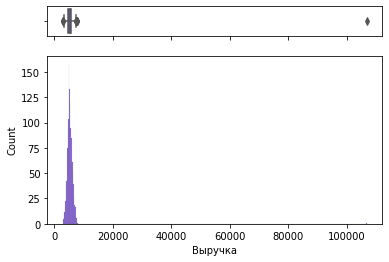

In [33]:
# сформируем переменные с цветами и периодами
palette=['#F2FD3F', '#EA3A8D', '#7247D7']
periods=['Препредыдущий_месяц', 'Предыдущий_месяц', 'Текущий_месяц']

# через цикл выведем таблицу с описательной статистикой, построим на одном графике гистограмму и боксплот
for period,color in zip(periods,palette):

    # выведем название периода на экран
    print(f"||||||||||||||||||||{period:^25}|||||||||||||||||||| \n")

    # выведем описательную статистику
    print(market_money
          .loc[market_money['Период']==period]
          .drop(columns='id')
          .describe()
          .round(2)
          .T)

    # формируем поле с двумя графиками
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # назначаем каждой оси соответствующий график
    sns.boxplot(data=market_money.loc[market_money['Период']==period], 
                x='Выручка',
                orient='h',
                ax=ax_box,
                color=color)
    sns.histplot(data=market_money.loc[market_money['Период']==period],
                 x='Выручка',
                 ax=ax_hist,
                 color=color)

    # уберем название оси X на боксплоте и выведем на экран результат
    ax_box.set(xlabel='')
    plt.show()
    
    # добавим пустую строку
    print('\n')

Сразу бросаются в глаза выбросы в данных. Для текущего месяца - это значения более 100000, а для предыдущих месяцев - значения около 0.

Обработаем эти выбросы.

В случае с экстремально высоким значением - предположим, что это некорректно записаное наблюдение. Все значения в выборке лежат в пределах 7000. Тогда логично будет отбросить десятки тысяч и оставить четырехзначную величину. Таким образом мы не нарушим форму распределение - исправленное наблюдение войдет в общую массу.


В случае с нулевым значением поступим так: запомним индексы пользователей, которые не покупали ничего в предыдущие месяцы, и по условию нашей исследовательской задачи оставим в выборке только тех, кто был активным пользователем и приобретал товары через интернет-магазин в течение последних трех месяцев. Удалим пользователей с соответствующими индексами при объединении наборов данных.

In [34]:
# посмотрим на строку с необычно высоким значением
market_money.loc[market_money['Выручка'] == 106862.2]

,id,Период,Выручка
98,215380,Текущий_месяц,106862.2


In [35]:
# проанализируем выручку магазина с данного пользователя и ближайших его соседей в выборке
market_money.iloc[93:102,:]

,id,Период,Выручка
93,215379,Предыдущий_месяц,4300.0
94,215379,Препредыдущий_месяц,4360.0
95,215379,Текущий_месяц,4394.9
96,215380,Препредыдущий_месяц,5051.0
97,215380,Предыдущий_месяц,6077.0
98,215380,Текущий_месяц,106862.2
99,215381,Препредыдущий_месяц,4503.0
100,215381,Предыдущий_месяц,5467.5
101,215381,Текущий_месяц,5783.4


Клиент с id = 215380 постепенно увеличивал объем покупок, что характерно и для двух других соседствующих с этим клиентом пользователей в выборке. Факты говорят о том, что лучшим решением здесь будет - отредактировать значение-выброс и изменить разрядность числа, чтобы не потерять данные. 

In [36]:
# заменим выброс другим значением
market_money.loc[market_money['Выручка'] == 106862.2,'Выручка'] = 6862.2

Теперь поработаем с нулевыми значениями выручки.

In [37]:
# выведем на экран только те записи, в которых выручка = 0
market_money.loc[market_money['Выручка'] == 0]

,id,Период,Выручка
0,215348,Препредыдущий_месяц,0.0
2,215348,Предыдущий_месяц,0.0
28,215357,Препредыдущий_месяц,0.0
29,215357,Предыдущий_месяц,0.0
34,215359,Предыдущий_месяц,0.0
35,215359,Препредыдущий_месяц,0.0


In [38]:
# запишем в отдельную переменную id таких пользователей
inactive_users = market_money.loc[market_money['Выручка'] == 0,'id'].unique()

In [39]:
# узнаем число таких пользователей
len(inactive_users)

3

К экстремально высокому значению применили логическую замену. Нули запомнили. Теперь построим еще раз распределения, но при этом исключим из выборки неактивных пользователей (тех, у кого не все три месяца были осуществлены покупки).

||||||||||||||||||||   Препредыдущий_месяц   |||||||||||||||||||| 

          count     mean     std  min     25%     50%     75%     max
Выручка  1300.0  4825.21  405.98  0.0  4583.0  4809.0  5053.5  5663.0


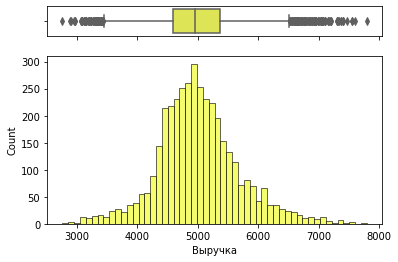



||||||||||||||||||||    Предыдущий_месяц     |||||||||||||||||||| 

          count     mean    std  min      25%     50%      75%     max
Выручка  1300.0  4936.92  739.6  0.0  4496.75  5005.0  5405.62  6869.5


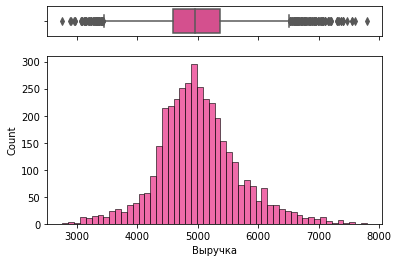



||||||||||||||||||||      Текущий_месяц      |||||||||||||||||||| 

          count     mean     std     min      25%      50%      75%     max
Выручка  1300.0  5238.04  836.37  2758.7  4706.05  5179.95  5761.72  7799.4


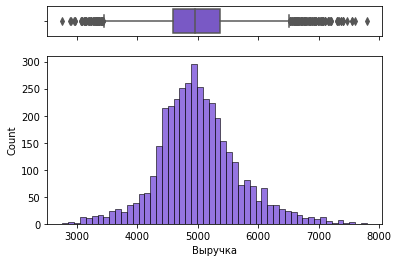

In [40]:
# сформируем переменные с цветами и периодами
palette=['#F2FD3F', '#EA3A8D', '#7247D7']
periods=['Препредыдущий_месяц', 'Предыдущий_месяц', 'Текущий_месяц']

# через цикл выведем таблицу с описательной статистикой, построим на одном графике гистограмму и боксплот

for period,color in zip(periods,palette):

    # выведем название периода на экран
    print(f"||||||||||||||||||||{period:^25}|||||||||||||||||||| \n")

    # выведем описательную статистику
    print(market_money
          .loc[market_money['Период']==period]
          .drop(columns='id')
          .describe()
          .round(2)
          .T)

    # формируем поле с двумя графиками
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # назначаем каждой оси соответствующий график
    sns.boxplot(data=market_money.loc[market_money['Период']==period], 
                x=market_money.query('id not in @inactive_users')['Выручка'],
                orient='h',
                ax=ax_box,
                color=color)
    sns.histplot(data=market_money.loc[market_money['Период']==period],
                 x=market_money.query('id not in @inactive_users')['Выручка'],
                 ax=ax_hist,
                 color=color)

    # уберем название оси X на боксплоте и выведем на экран результат
    ax_box.set(xlabel='')
    plt.show()
    
    # добавим пустую строку
    print('\n')

Теперь распределения выглядят нормально и практически одинаково.
Выручка от месяца к месяцу увеличивалась в средних значениях. При этом медианное значение убедительно доказывает возрастание типичной для этой выборки величины показателя. В текущем месяце она достигло значений свыше 5100 рублей.
В среднем прирост выручки составляет около 200 рублей ежемесячно.
Таким образом, мы наблюдаем замечательную динамику по выручке с активных клиентов сервиса.

Перейдем к исследовательскому анализу последнего набора данных. 

### Исследовательский анализ данных набора `money`

В последнем наборе данных тоже только одна переменная интересна для исследования. Это прибыль с пользователей. Проанализируем её по тому же принципу.

          count  mean   std   min  25%   50%   75%   max
Прибыль  1300.0   4.0  1.01  0.86  3.3  4.04  4.67  7.43


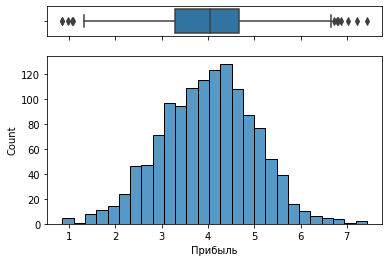

In [41]:
# выведем описательную статистику
print(money.drop(columns='id').describe().round(2).T)

# формируем поле с двумя графиками
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# назначаем каждой оси соответствующий график
sns.boxplot(data=money, x='Прибыль', orient='h', ax=ax_box)
sns.histplot(data=money, x='Прибыль', ax=ax_hist)
 
# уберем название оси X на боксплоте и выведем на экран результат
ax_box.set(xlabel='')
plt.show()

Распределение среднемесячной прибыли покупателя за последние 3 месяца близко к нормальному. Среднее и медианное значения практически совпадают. Типичным для данной выборки является значение прибыли - 4. Вместе с этим, 75% покупателей в этот период приносили более 3,3 рублей прибыли. Максимально магазина получал от продаж клиентам почти 7,5 рублей прибыли.  

Итак, подведем итоги исследовательскому анализу данных, которые представлены в четырех датасетах. 

**Коммуникация с клиентом**

В нашей выборке присутсвуют лояльные клиенты, которые зарегистрировались на сервисе более года назад. Только 1/3 пользователей пользуются премиум услугами магазина, а также около четверти пользователей не принимают участия в маркетинговом взаимодействии с клиентами. Охват готовых к общению клиентов позволяет проводить по каналам взаимодействия примерно 4 маркетинговых коммуникаций  в среднем, как в текущем месяце, так и за последние полгода.


**Продуктовое поведение**

Из четырех товаров, купленных в интернет-магазине, только один будет из категории 'Мелкая бытовая техника и электроника' и 'Кухонная посуда'. В совокупности на эти категории приходилось столько же продаж, сколько на самую популярную категорию - товары для детей. Пользователи из выборки в среднем за последние полгода приобретали товары из трех категорий. И примерно столько же товаров клиенты добавляют в корзину, но не оформляют.

**Поведение на сайте**

В среднем пользователи проводили одинаковое время на сайте в предыдущем и текущем месяцах - около 13 минут. За это время пользователи успевают посетить в среднем 5 страниц сайта. Большинство клиентов просматривают до 11 страниц за сеанс. Лишь четверть из них - до 20. Беспокоит число сбоев, которые коснулись покупателя во время посещения сайта. Их примерно 4 на типичного пользователя из выборки.

**Финансовое поведение**

Динамика выручки от пользователей положительная от месяца к месяцу. Средний рост медианного значения - 200 рублей каждый месяц. К теущему месяцу мы получили занчения свыше 5100 рублей выручки от одного пользователя.


Отбор клиентов с покупательской активностью не менее трёх месяцев осуществили выявив нулевые значения выручки в предыдущих месяцах. Эти клиенты ничего не покупали в этот период. Мы запомнили идентификаторы таких клиентов, чтобы на этапе объединения таблиц удалить их из выборки. Всего таких пользователей - трое.

## Объединение таблиц

На четвертом шаге "Объединение таблиц" объединим все данные в один набор для дальнейшего использования при моделировании.

Для начала таблицу с данными о выручке (набор `market_money`) и времени на сайте (набор `market_time`) нужно развернуть, чтобы в отдельный столбец была отнесена информация по каждому периоду.

Затем объединим данные в одну таблицу.

Из единой таблицы удалим записи с неактивными пользователями (клиенты с покупательской активностью менее трёх месяцев).

In [42]:
# составим сводную таблицу из датасета
market_money_pivot = market_money.pivot(index='id', columns='Период', values='Выручка').reset_index()

In [43]:
# посмотрим на названия столбцов в сводной таблице
market_money_pivot.columns.to_list()

['id', 'Предыдущий_месяц', 'Препредыдущий_месяц', 'Текущий_месяц']

In [44]:
# перепишем названия столбцов
market_money_pivot.columns = ['id','Выручка_предыдущий_месяц','Выручка_препредыдущий_месяц','Выручка_текущий_месяц']

In [45]:
# проверим результат и выведем первые 5 строк нового набора данных
market_money_pivot.head()

,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5


Один набор данных привели к нужному виду. Займемся другим и проведем те же преобразования.

In [46]:
# составим сводную таблицу из датасета
market_time_pivot = market_time.pivot(index='id', columns='Период', values='Время_на_сайте').reset_index()

In [47]:
# посмотрим на названия столбцов в сводной таблице
market_time_pivot.columns

Index(['id', 'Предыдущий_месяц', 'Текущий_месяц'], dtype='object', name='Период')

In [48]:
# перепишем названия столбцов
market_time_pivot.columns = ['id','Время_предыдущий_месяц','Время_текущий_месяц']

In [49]:
# проверим результат и выведем первые 5 строк нового набора данных
market_time_pivot.head()

,id,Время_предыдущий_месяц,Время_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


С учетом всех преобразований и трансформаций, мы готовы объединить данные в один набор.

Учтем, что мы уже отобрали клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период, и записали их идентификаторы в переменную `inactive_users`.

Будем действовать так:
- по `id` объединим три датасета;
- удалим из объединенного датасета клиентов с идентификаторами, записанными в `inactive_users`.

In [50]:
# формируем объедиенный набор данных
data_market = (market_file
               .merge(market_time_pivot, on='id', how='left')
               .merge(market_money_pivot, on='id', how='left')
               .query('id not in @inactive_users'))

In [51]:
# выведем информацию о новом датасете на экран
data_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   object 
 2   Тип_сервиса                          1297 non-null   object 
 3   Разрешить_сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

In [52]:
# напечатаем на экране первые 5 строк нового датасета
data_market.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Время_предыдущий_месяц,Время_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
1,215349,Снизилась,Премиум,Да,4.4,4,819,0.75,Товары_для_детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
2,215350,Снизилась,Стандарт,Нет,4.9,3,539,0.14,Домашний_текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
3,215351,Снизилась,Стандарт,Да,3.2,5,896,0.99,Товары_для_детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
4,215352,Снизилась,Стандарт,Нет,5.1,3,1064,0.94,Товары_для_детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
5,215353,Снизилась,Стандарт,Да,3.3,4,762,0.26,Домашний_текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5


Объединение прошло успешно.

Все поля из трех датасетов теперь в одном наборе данных, и неактивных пользователей в нем нет. 

Можно переходить к следующим этапам исследования.

## Корреляционный анализ

На данном шаге проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. 

Нам необходимо зафиксировать факт мультиколлинеарности признаков и при необходимости устраните её.

Поскольку часть количественных признаков распределна ненормально, а нам необходимо проанализировать еще и взаимосвязь таких признаков с целевой переменной, воспользуемся коэффициентами корреляции $\phi_K$.

In [53]:
# рассчитаем коэффициенты phi
# создаём список с наименованиями непрерывных признаков
interval_cols = data_market.select_dtypes(include='float').columns

# считаем корреляции по итоговой таблице с количественными признаками и целевой переменной, исключая `id`
data_market_phik = (data_market
                    .drop(columns='id')
                    .select_dtypes(include='number')
                    .join(data_market['Покупательская_активность'], how='right')
                    .phik_matrix(interval_cols=interval_cols))

In [54]:
data_market_phik

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Время_предыдущий_месяц,Время_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Покупательская_активность
Маркет_актив_6_мес,1.000000,0.080454,0.000000,0.278729,0.205783,0.215195,0.147270,0.373372,0.322162,0.329320,0.149129,0.312243,0.061237,0.546370
Маркет_актив_тек_мес,0.080454,1.000000,0.676032,0.000000,0.246726,0.142490,0.116310,0.000000,0.165172,0.082378,0.054683,0.000000,0.000000,0.000000
Длительность,0.000000,0.676032,1.000000,0.000000,0.767452,0.850798,0.679589,0.516404,0.210075,0.673837,0.000000,0.180828,0.084747,0.000000
Акционные_покупки,0.278729,0.000000,0.000000,1.000000,0.199417,0.246303,0.000000,0.350551,0.313361,0.287061,0.065412,0.225681,0.064175,0.506991
Средний_просмотр_категорий_за_визит,0.205783,0.246726,0.767452,0.199417,1.000000,0.335031,0.069908,0.294140,0.218956,0.236461,0.100332,0.176770,0.095795,0.539221
Неоплаченные_продукты_штук_квартал,0.215195,0.142490,0.850798,0.246303,0.335031,1.000000,0.000000,0.310950,0.193912,0.157826,0.193752,0.189721,0.166152,0.404382
Ошибка_сервиса,0.147270,0.116310,0.679589,0.000000,0.069908,0.000000,1.000000,0.159549,0.193757,0.131144,0.000000,0.140057,0.000000,0.223697
Страниц_за_визит,0.373372,0.000000,0.516404,0.350551,0.294140,0.310950,0.159549,1.000000,0.385717,0.349054,0.151372,0.339933,0.116067,0.746825
Время_предыдущий_месяц,0.322162,0.165172,0.210075,0.313361,0.218956,0.193912,0.193757,0.385717,1.000000,0.336856,0.179691,0.354463,0.232417,0.603903
Время_текущий_месяц,0.329320,0.082378,0.673837,0.287061,0.236461,0.157826,0.131144,0.349054,0.336856,1.000000,0.162439,0.326462,0.295605,0.569310


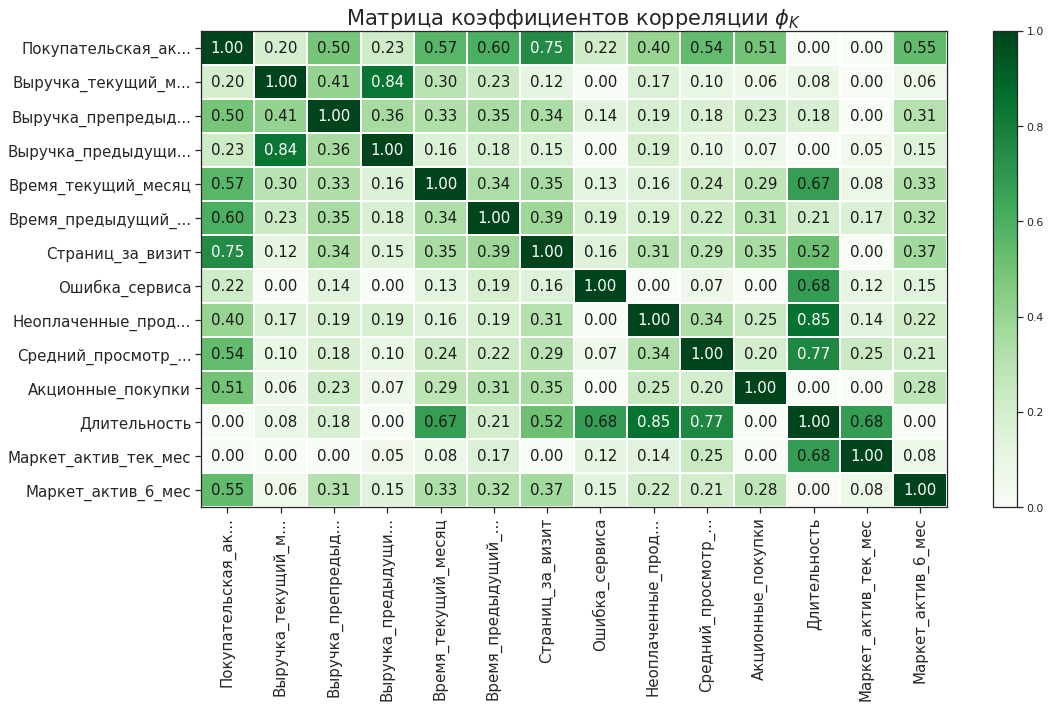

In [135]:
# построим матрицу корреляции
plot_correlation_matrix(
    data_market_phik.values,
    x_labels=data_market_phik.columns,
    y_labels=data_market_phik.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица коэффициентов корреляции $\phi_K$',
    fontsize_factor=1.5,
    figsize=(16, 10)
)

Самые большие по величине коэффициенты - между признаками: 
- Длительностью и количеством неоплаченных продуктов в корзине (0.85);
- Величиной выручки в текущем месяце и предыдущим (0.84);
- Длительностью и средним числом просмотренных категорий за визит (0.77).

Все логично. Чем дольше пользователь зарегистрирован на сервисе - тем больше у него накопилось неоплаченных продуктов в корзине. 
Взаимосвязь величины выручки за разные периоды также не вызывает недоумения. А вот последняя взаимосвязь довольно интересная - у лояльных пользователей больше число просмотренных категорий за визит. Это означает, что они лучше знакомы с сервисом и пытаются удовлетворить свои потребности в товарах и услугах в широком ассортименте. Вновь зарегистрированные пользователи, наборот, прибегают к поиску продуктов лишь в нескольких категориях.


Что же касается целевого признака (`Покупательская_активность`), то с ним наблюдается тесная взаимосвязь между:
- Количеством страниц за визит (0.75);
- Временем за предыдущий период и временем за текущий период (0.60);
- Средним числом просмотренных категорий за визит (0.54).

Эти маркеры хорошо подсвечивают нам следующий вывод -  поведение пользователей интернет-магазина тесно коррелирует с тем, снизилась ли их покупательская активность или нет. От этих признаков можно ожидать высокую объясняющую силу при моделировании. 

Вместе с этим нет взаимосвязи между целевым признаком и длительностью, а также числом маркетинговых активностей в текущем месяце.


Проверим наши гипотезы далее на этапе построения моделей.

In [1]:
# сохраним признаки для проверки vif в отдельный датасет
data_market_vif = (data_market
                    .set_index('id')
                    .select_dtypes(include='number')
                    .assign(const=1))

NameError: name 'data_market' is not defined

In [137]:
# создадим таблицу с VIF-коэффициентами
# задаем датафрейм
vif_data = pd.DataFrame()

# сохраняем имена признаков из исходной таблицы в таблицу c VIF
vif_data["Признак"] = data_market_vif.columns

# рассчитываем VIF-значения для каждого признака
vif_data["VIF"] = [variance_inflation_factor(data_market_vif.values, i)
                          for i in range(len(data_market_vif.columns))]
  
# выведем таблицу на экран
vif_data

,Признак,VIF
0,Маркет_актив_6_мес,1.220484
1,Маркет_актив_тек_мес,1.044468
2,Длительность,1.099468
3,Акционные_покупки,1.185893
4,Средний_просмотр_категорий_за_визит,1.178597
5,Неоплаченные_продукты_штук_квартал,1.198242
6,Ошибка_сервиса,1.079242
7,Страниц_за_визит,1.418158
8,Время_предыдущий_месяц,1.526835
9,Время_текущий_месяц,1.320337


Судя по VIF и матрице корреляций мультиколлинеарности в признаках нет. VIF-значения меньше 5. Коэффициенты корреляции по модулю меньше 0,9.

## Использование пайплайнов

На этом шаге нам необходимо применить изученные модели обучения с учителем и проверить их качество. Для этого будут использоваться пайплайны.

При этом необходимо предусмотреть следующие моменты.

На этапе подготовки модели:
- Использовать ColumnTransformer для подготовки данных;
- Количественные и категориальные признаки обработать раздельно;
- Для кодирования категориальных признаков использовать как минимум два кодировщика;
- Для масштабирования количественных признаков использовать как минимум два скейлера;

На этапе обучения модели:
- Обучить четыре модели: 
    + KNeighborsClassifier(), 
    + DecisionTreeClassifier(), 
    + LogisticRegression(),
    + SVC(). 
- Для каждой модели подобрать как минимум один гиперпараметр;
- Выбрать подходящую для задачи метрику и использовать эту метрику при подборе гиперпараметров.

На этапе оценки качества моделей:
- Выбрать лучшую модель, используя заданную метрику. 

На этом этапе предлагается применить одну из стратегий:
1) использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
2) использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

При формировании пайплайна было решено:
Для кодирования категориальных признаков использовать LabelEncoder (для целевого признака) и OneHotEncoder (для независимых признаков).
Для масштабирования всех количественных признаков использовать StandardScaler и MinMaxScaler.

Обучение четырех моделей будет произведено с учетом настройки следующих гиперпараметров: 
- KNeighborsClassifier() - n_neighbors: от 3 до 20 не включительно;
- DecisionTreeClassifier() - max_depth: от 2 до 10 не включительно; 
- LogisticRegression() - C: от 1 до 5 не включительно;
- SVC() - kernel: 'linear' или 'rbf'. 

Подходящей для задачи метрикой, которая будет использоваться при подборе гиперпараметров, выглядит ROC-AUC. Она позволяет оценить качество модели в целом, не чувствительна к дисбалансу классов и может быть применена в подобной задаче бинарной классификации.

При выборе лучшей модели будем использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт лучшую модель.

In [138]:
# сохраняем признаки и целевую переменную в отдельные датафреймы
X = data_market.set_index('id').drop(['Покупательская_активность'], axis=1)
y = data_market['Покупательская_активность']

# делим выборку на тренировочную и тестовую 
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [139]:
# кодирование целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [140]:
# создаём списки с названиями признаков
ohe_columns = ['Тип_сервиса',
              'Разрешить_сообщать',
              'Популярная_категория']
num_columns = ['Маркет_актив_6_мес',
               'Маркет_актив_тек_мес',
               'Длительность',
               'Акционные_покупки',
               'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал',
               'Ошибка_сервиса',
               'Страниц_за_визит',
               'Время_предыдущий_месяц',
               'Время_текущий_месяц',
               'Выручка_предыдущий_месяц',
               'Выручка_препредыдущий_месяц',
               'Выручка_текущий_месяц']

Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование.

In [141]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
    )

Теперь сформируем общий пайплайн для подготовки категориальных и количественных данных.

In [142]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Создаём итоговый пайплайн, в которой указываем пайплайн подготовки данных и задаем модель логистической регрессии в качестве базовой.

In [143]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

Запишем словари с гиперпараметрами для четырех моделей.

In [144]:
# запишем словари для моделей
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(3, 7),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga', 
            penalty='l1'
        )],
        'models__C': range(1,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
        # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear','rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
]

In [145]:
# проверим как произошло кодирование целового признака
label_encoder.inverse_transform([0, 1])

array(['Прежний_уровень', 'Снизилась'], dtype=object)

При помощи рандомизированного поиска осуществим отбор лучшей модели по заданным гиперпараметрам.

In [146]:
# активируем поиск лучшей модели 
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# обучаем лучшую модель
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидацинной выборке:', randomized_search.best_score_)

# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_pred = randomized_search.predict(X_test)
y_pred_proba = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred_proba)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['Мар

В результате мы получили в качестве лучшей модели LogisticRegression(), с гиперпараметром C=13 для лассо-регуляризации. Лучшим скейлером для количественных данных выступает StandardScaler().

Модель показывает хороший результат как на тренировачных, так и на тестовых данных. Качество по метрике свыше 0.9. 

Можно переходить к оценке важности признаков.

## Анализ важности признаков

На данном этапе проведем оценку важности признаков для лучшей модели и построим график важности с помощью метода SHAP. 


Подготовим данные для построения графика важности признаков.

In [147]:
# сохраним параметры предобработки в отдельную переменную
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

# подготовим тестовый датасет по лучшей предобработке 
X_test_prep = preprocessor.transform(X_test)

# получение всех имен признаков в один список
all_features = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# создание тестового датафрейма с соответствующими именами признаков
X_test_shap = pd.DataFrame(X_test_prep, columns=all_features)

In [148]:
# сохраним параметры лучшей модели в отдельную переменную 
best_model = randomized_search.best_estimator_['models']

In [149]:
# обучаем LinearExplainer на тестовом датафрейме по лучшей модели
explainer = shap.LinearExplainer(best_model, X_test_shap)

In [150]:
# сохраняем shap_values
shap_values = explainer(X_test_shap)

In [151]:
# сохраним значения SHAP с именами признаков в отдельный датафрейм
shap_df = pd.DataFrame(shap_values.values, columns=all_features)

In [152]:
# возьмем все SHAP-значения по модулю, чтобы при расчете среднего отрицательные значения не занулили среднее
for column in all_features:
    shap_df[column] = shap_df[column].abs()

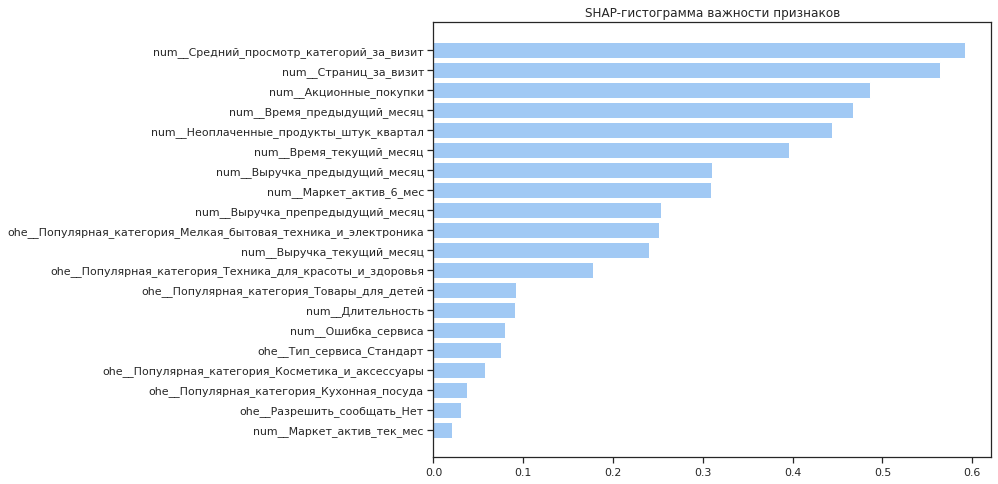

In [153]:
# построим гистограмму с SHAP-значениями каждого признака
mean_shap_df = shap_df.mean().reset_index()
mean_shap_df.columns = ['Признак', 'SHAP-значение']
mean_shap_df = mean_shap_df.sort_values(
    by='SHAP-значение',
)

plt.figure(figsize=(10, 8))
plt.barh(
    mean_shap_df['Признак'],
    mean_shap_df['SHAP-значение'],
)
plt.title('SHAP-гистограмма важности признаков')
plt.show()

Итак, сделаем выводы о значимости признаков.

Среди малозначимых признаков выделим следующие:
- категории товаров;
- тип сервиса;
- разрешение сообщать о рассылках.

Таким образом, часть признаков продуктового поведения и коммуникаций с клиентом не оказывают существенного влияния на прогноз модели.

Сильнее всего такое влияние имеют показатели:
- акционных покупок;
- страниц за визит;
- просмотра категорий за визит.

Прогноз значения целевого признака меняется существенным образом, когда происходит изменение доли товаров, приобретенных по акции, количества просмотренных страниц на сайте за один визит и проведенного на сайте времени.

С учетом этих выводов можно переходить к сегментации клиентов сервиса и выработке рекомендаций по повышению покупательской активности.

## Сегментация покупателей

На шаге 8 "Сегментация покупателей" мы выполним анализ групп покупателей. Для этого необходимо использовать результаты моделирования и данные о прибыльности покупателей.

Нужно выбрать группу покупателей и предложить, как увеличить её покупательскую активность.
- Требуется провести графическое и аналитическое исследование выбранной группы покупателей;
- Сформулировать предложения по работе с данным сегментом для увеличения покупательской активности.

По итогам анализа сделаем выводы о сегментах покупателей.

Для начала подготовим данные для сегментации.

In [154]:
# получим прогнозные вероятности снижения покупательской активности для train и test 
X_train['Прогноз_вероятности'] = randomized_search.predict_proba(X_train)[:,1]
X_test['Прогноз_вероятности'] = randomized_search.predict_proba(X_test)[:,1]

# объединим данные в один датафрейм
X_segmentation = X_train.append(X_test)

# установим в качестве индекса `id` в датасете `money`
# объединим данные с X_segmentation
X_segmentation = X_segmentation.join(money.set_index('id'), how='left')

Данные подготовлены. Теперь можно определить целевые группы пользователей.

Логично предположить, что в нашем кейсе особое значение имеют те пользователи, которые приносят высокую прибыль компании. Поскольку распределение пользователей по прибыли по форме напоминает нормальное, мы можем выбрать определенный процентиль, и на основе его значения сформировать группу с выскоприбыльными пользователями. 

В нашей исследовательской задаче такой процентиль может быть определен на уровне третьего квартиля. Будем считать, что *пользователи с уровнем прибыли выше третьего квартиля* - **группа высокоприбыльных клиентов**.

Но нам необходимо также учитывать и прогноз вероятности. Определить такой порог для сегментации можно только после исследовательского анализа. 

count    1297.00
mean        0.39
std         0.37
min         0.00
25%         0.07
50%         0.21
75%         0.79
max         1.00
Name: Прогноз_вероятности, dtype: float64


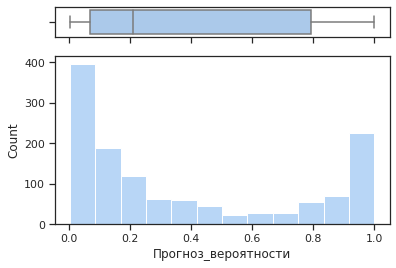

In [155]:
# выведем описательную статистику
print(X_segmentation['Прогноз_вероятности'].describe().round(2))

# формируем поле с двумя графиками
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# назначаем каждой оси соответствующий график
sns.boxplot(data=X_segmentation, x='Прогноз_вероятности', orient='h', ax=ax_box)
sns.histplot(data=X_segmentation, x='Прогноз_вероятности', ax=ax_hist)
 
# уберем название оси X на боксплоте и выведем на экран результат
ax_box.set(xlabel='')
plt.show()

Распределение прогнозных значений вероятности никак не походит на нормальное. 

По результатам анализа целевого признака около 60% пользователей не изменили свою покупательскую активность, а у других 40% - она снизилась. 

Так и по форме распределения прогнозных значений вероятности снижения покупательской активности виден явный перекос.

В целях сегментирования предлагается отобрать:
- Первую квартильную группу пользователей по прогнозу вероятности (меньше порога 25% распределения);
- Четвертую квартильную группу пользователей по прогнозу вероятности (выше порога 75% распределения).

Для начала проверим соотношение категорий таких пользователей в выборке по фактическим классам (признак `Покупательская_активность`) и по распределению вероятностей прогноза снижения активности, полученному по лучшей модели (`Прогноз_вероятности`).

In [156]:
# сформируем категории клиентов на основе прибыли и прогноза вероятности
profitable_high_proba = X_segmentation.loc[
                            (X_segmentation['Прогноз_вероятности'] > X_segmentation['Прогноз_вероятности'].quantile(.75)) &
                            (X_segmentation['Прибыль'] > X_segmentation['Прибыль'].quantile(.75))]

profitable_low_proba = X_segmentation.loc[
                            (X_segmentation['Прогноз_вероятности'] < X_segmentation['Прогноз_вероятности'].quantile(.25)) &
                            (X_segmentation['Прибыль'] > X_segmentation['Прибыль'].quantile(.75))]

profitable_high_proba['Сегмент'] = 'Высокоприбыльные_высокий_риск'
profitable_low_proba['Сегмент'] = 'Высокоприбыльные_низкий_риск'
profitable_segment = profitable_high_proba.append(profitable_low_proba)

/tmp/ipykernel_31/3726451377.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profitable_high_proba['Сегмент'] = 'Высокоприбыльные_высокий_риск'
/tmp/ipykernel_31/3726451377.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profitable_low_proba['Сегмент'] = 'Высокоприбыльные_низкий_риск'


In [157]:
# соотношение покупателей с прежним уровнем активности и покупателей, у которых снизилась активность в выборке
print(f"Cоотношение групп пользователей по фактической покупательской активности: \
{round(len(market_file.loc[market_file['Покупательская_активность'] == 'Прежний_уровень', ['Покупательская_активность']]) / len(market_file.loc[market_file['Покупательская_активность'] == 'Снизилась', ['Покупательская_активность']]), 2)}")


# соотношение квартильных групп пользователей по прогнозу вероятности снижения покупательской активности 
print(f"Cоотношение квартильных групп пользователей по прогнозной вероятности снижения покупательской активности: \
{len(profitable_high_proba)/len(profitable_low_proba)}")

Cоотношение групп пользователей по фактической покупательской активности: 1.61
Cоотношение квартильных групп пользователей по прогнозной вероятности снижения покупательской активности: 0.8191489361702128


Соотношение примерно одинаковое. Можем продолжать анализ по данным характеристикам пользователей.

Повторим еще раз. На данный момент мы имеем следующие сегменты целевой аудитории:
- высокоприбыльные клиенты с низкой вероятностью снижения покупательской активности;
- высокоприбыльные клиенты с высокой вероятностью снижения покупательской активности.

Будем продолжать исследование в разрезе этих сегментов.

Построим на различия в этих сегментах по количественным показателям на графике. 

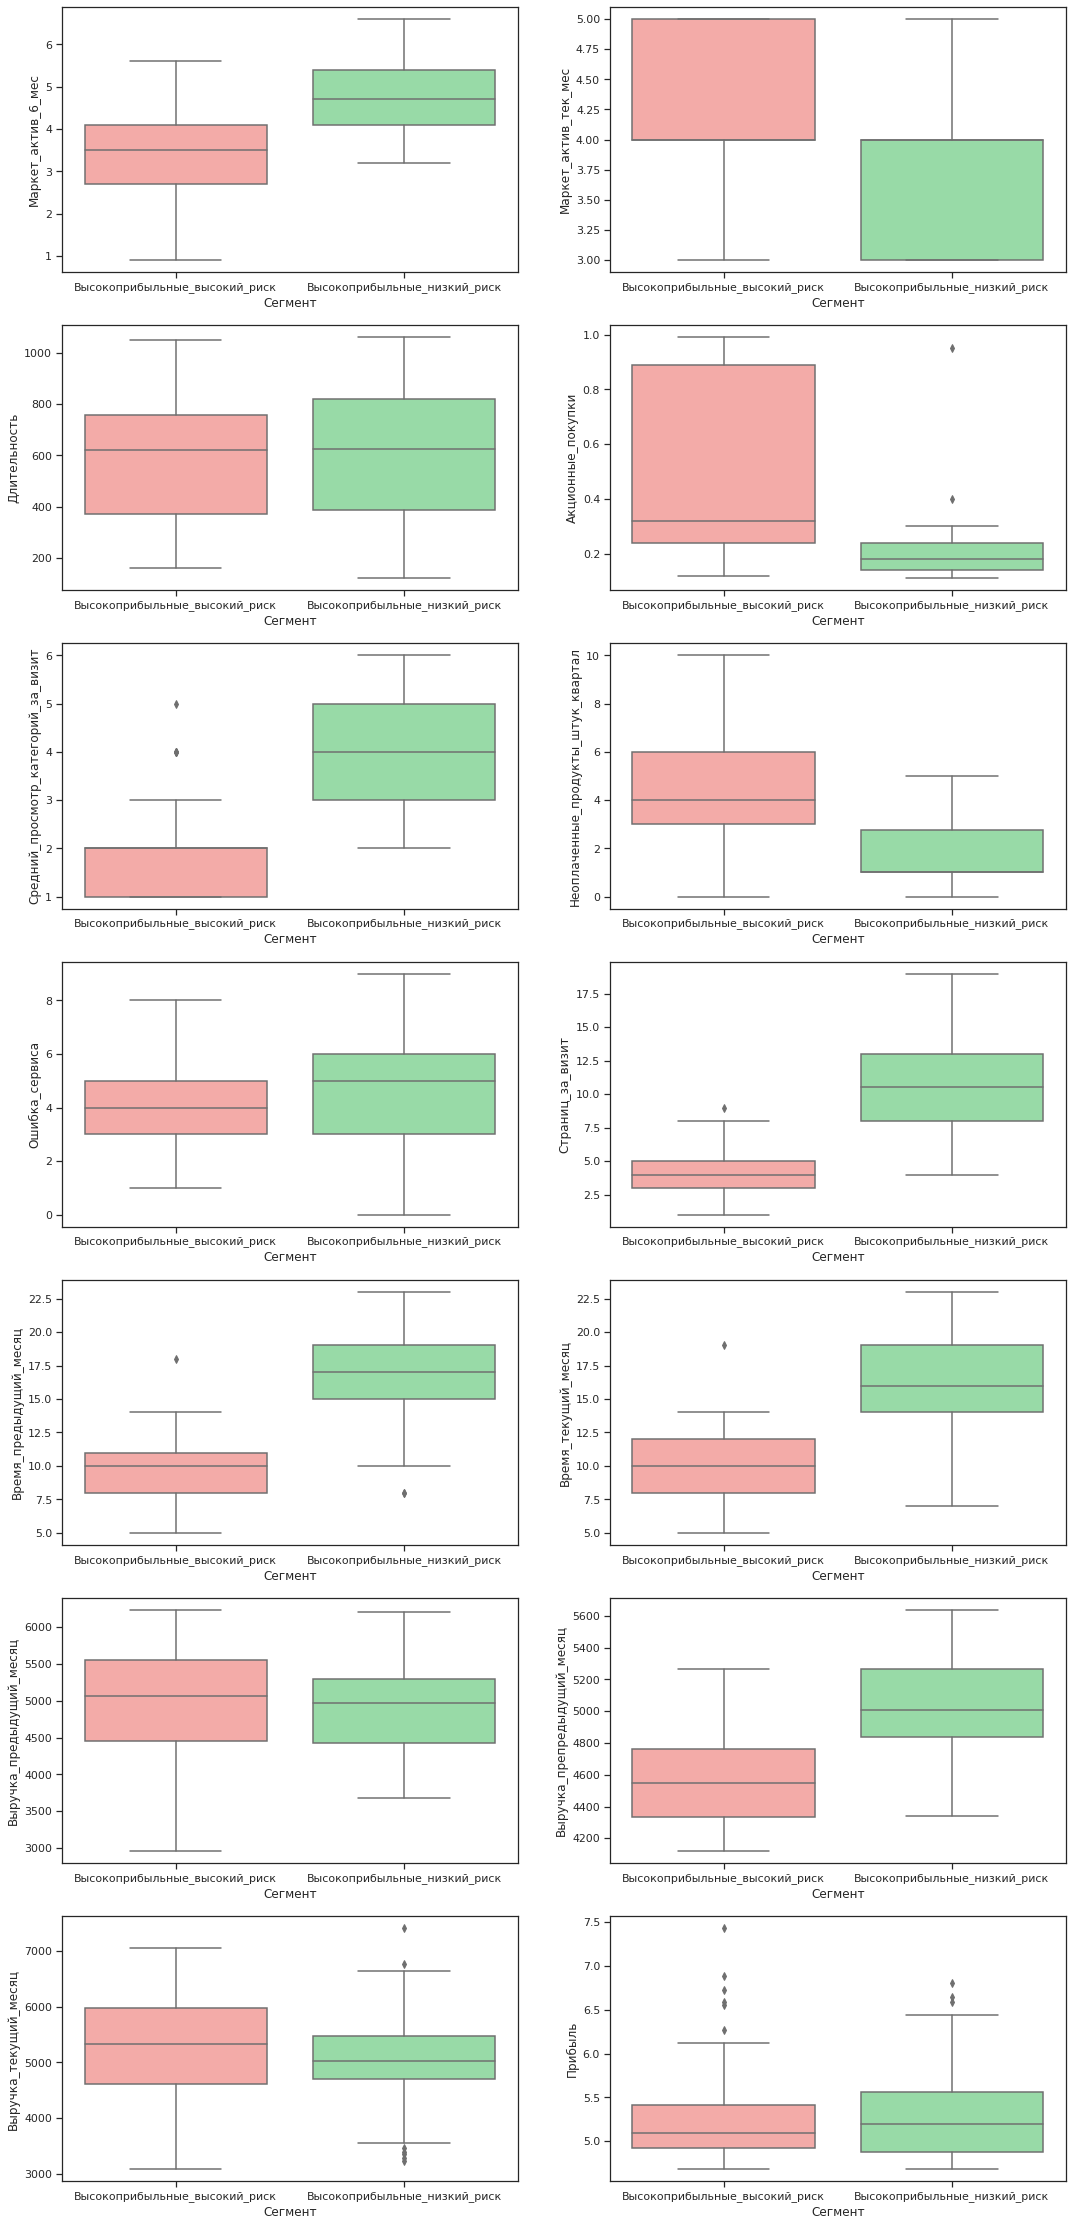

In [158]:
# сохраним количественные признаки для графика
feature_to_boxplot = (profitable_segment
                      .select_dtypes(include='number')
                      .drop(columns=['Прогноз_вероятности'])
                      .columns)
 
# построим график
fig_box = plt.figure(figsize=(18,40)) # задаем параметры графика
subplt_box = 1 # номер начального axes
sns.set_theme(style="ticks", palette="pastel") # установим стиль

# при помощи цикла отрисуем boxplot для каждого количественного признака
for feature in feature_to_boxplot:
    ax_box = fig_box.add_subplot(7, 2, subplt_box)
    sns.boxplot(data=profitable_segment, 
            x='Сегмент', 
            y=feature,
        palette=["r", "g"])
    plt.subplots_adjust(wspace=0.2, hspace=0.2) 
    subplt_box+=1
plt.show()

Итак, следующие показатели выше у группы клиентов с низким риском снижения покупательской активности:
- число маркетинговых взаимодействий за последние 6 месяцев;
- число просмотренных категорий за визит;
- число просмотренных страниц за визит;
- проведенное время на сайте.

То есть высокоприбыльные и низкорисковые клиенты охотнее, чем пользователи с высоким риском снижения покупательской активности, взаимодействуют с сервисом. Это сказывается на вовлеченности пользователей, их продуктовом поведении, действиях на сайте и откликах на маркетинговые кампании.

Также удалось выявить показатели, которые выше у высокоприбыльных пользователей с высоким риском снижения покупательской активности.
Речь идет о доле товаров, приобретенных по акции и количестве неоплаченных продуктов в корзине. 

То есть для высокоприбыльных и высокорисковых клиентов характерной чертой является то, что они откладывают покупки на будущие периоды, когда их финансовые возможности будут соразмеры потребностям в товарах интернет-магазина, либо они решаются купить товар только тогда, когда на него распространяется акционное предложение.

Что же касается длительности регистрации на сайте и ошибок сервиса - то тут мы можем наблюдать приблизительно одинаковую ситуацию как у одной группы клиентов, так и у другой. Это признаки, которые не изменяются в зависимости от выбранных нами параметров сегментации клиентов. 

Наконец, примечательно, то что последние два месяца величина выручки клиентов с высоким риском снижения покупательской активности приносят столько же, сколько и клиенты с низким риском, хотя в препредыдущем месяце выручка от клиентов с низким риском была выше.

No handles with labels found to put in legend.


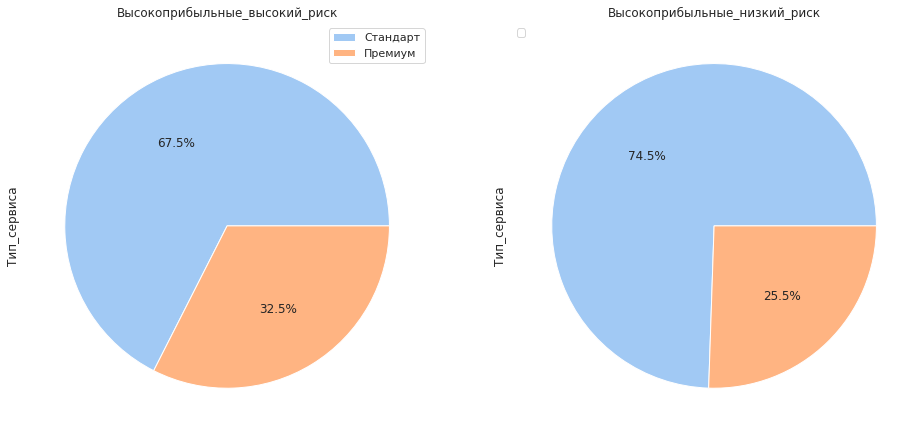

No handles with labels found to put in legend.


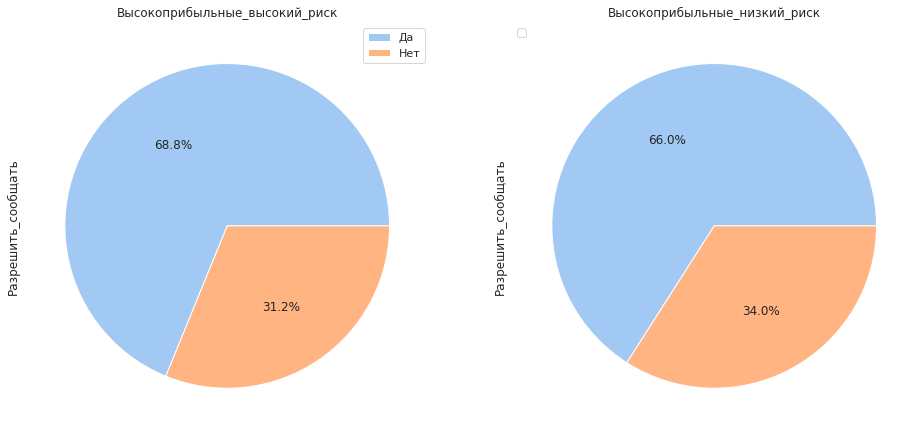

No handles with labels found to put in legend.


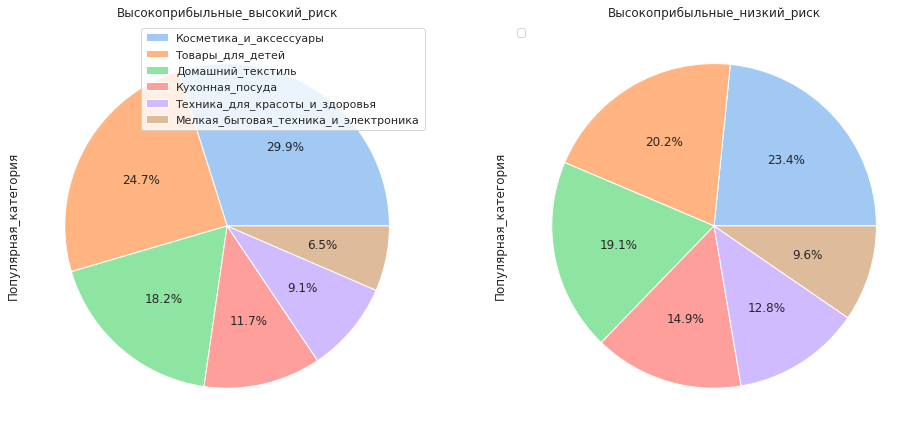

In [159]:
# сформируем переменную с названиями категориальных признаков
feature_to_pieplot = (profitable_segment
                      .select_dtypes(exclude='number')
                      .drop(columns='Сегмент')
                      .columns)

# при помощи цикла построим круговые диаграммы для каждого признака
for feature in feature_to_pieplot:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    df1 = profitable_segment.loc[profitable_segment['Сегмент'] == 'Высокоприбыльные_высокий_риск', feature].value_counts(normalize=True) * 100
    df1.plot.pie(autopct='%1.1f%%', startangle=0, ax=axes[0], labels=None, title='Высокоприбыльные_высокий_риск', legend=True)

    df2 = profitable_segment.loc[profitable_segment['Сегмент'] == 'Высокоприбыльные_низкий_риск', feature].value_counts(normalize=True) * 100
    df2.plot.pie(autopct='%1.1f%%', startangle=0, ax=axes[1], labels=None, title='Высокоприбыльные_низкий_риск', legend=True)

    plt.legend(loc='upper left')
    plt.show()

Напрашиваются следующие выводы:

Удивительно, но у сегмента пользователей "Высокоприбыльные_высокий_риск" больше премиальных подписок. То есть та категория пользователей, которых мы считаем склонными к снижению покупательской активности, предпочитает использовать премиальные услуги сервиса.

Судя по графику, пользователи двух рассматриваемых сегментов солидарны в вопросе доступа к коммуникации.

Существенных структурных различий между сегментами по показателю `Популярная_категория` не наблюдается, явный перекос по группе товаров "Кухонная_посуда".

По итогам анализа сформулируем выводы о сегментах покупателей и предложения по работе с рассматриваемыми сегментами для увеличения покупательской активности.

- Мы наблюдаем относительно низкую вовлеченность пользователей с высоким риском снижения покупательской активности во взаимодействие с компанией. Они меньше проводят времени на сайте и реже коммуницируют с сервисом.
- Пользователи, входящие в этот сегмент, откладывают покупки на будущее и чаще совершают их по акции.
- У этой группы клиентов больше подписок класса "Премиум".

Мы видим, что клиенты с высокой вероятностью снижения покупательской активности готовы и дальше взаимодействовать с интернет-магазином - они выбирают премиальный уровень сервиса, ждут акций и специальных предложений. Их приверженность бренду доказана, вместе с этим они важный источник прибыли компании. Ключевой проблемой здесь видится низкая вовлеченность таких пользователей в маркетинговые коммуникации.

Компания должна лучше выстраивать общение с этой категорией клиентов, адресно предлагать специальные предложения и скидки, запускать дополнительные распродажи, а в рамках премиум-пакета предложить дополнительные услуги по рассрочке оплаты за товар и стоимости доставки. Прежде всего персональные предложения должны быть направлены на категорию товаров "Товары для детей" и "Косметика и аксессуары", которые занимают большую долю в покупках клиентов обозначенного сегмента.

Тогда цикл отложенных покупок у данного сегмента покупателей сократится, что дополнительно увеличит выручку компании. 

## Общий вывод

**Описание исследования**

В рамках проекта было необходимо разработать модель машинного обучения, которая будет предсказывать вероятность снижения покупательской активности клиентов в ближайшие три месяца. Это позволит интернет-магазину «В один клик» персонализировать предложения для постоянных покупателей и тем самым повысить их лояльность.

Задачи проекта:

- Промаркировать уровень активности постоянных покупателей.
- Собрать данные о клиентах по четырём группам.
- Выделить сегменты покупателей и разработать для них персонализированные предложения.

Данные проекта включают информацию о поведении покупателей на сайте, их коммуникации с интернет-магазином, продуктовом поведении, времени, проведённом на сайте, и прибыли, которую принёс каждый покупатель за последние три месяца.

На этапе предобработки мы исправили ошибки в названиях столбцов и категорий, провели исследовательский анализ данных, исключили неактивных пользователей (тех кто не совершал покупки в каждый из трех рассматриваемых месяцев), объединили четыре таблицы с данными в одну.

В ходе работы были использованы методы предобработки данных с применением ColumnTransformer в пайплайне. Количественные и категориальные признаки были обработаны раздельно в пайплайне. Для кодирования категориальных признаков было использовано минимум два кодировщика: LabelEncoder и OneHotEncoder. А для масштабирования количественных — минимум два скейлера: StandartScaler и MinMaxScaler.

Для каждой модели выбрали как минимум один гиперпараметр, который будет влиять на её работу. Например, для KNeighborsClassifier() можно попробовать разные значения k (количество соседей), для DecisionTreeClassifier() — максимальную глубину дерева, для LogisticRegression() — коэффициент регуляризации C, а для SVC() — ядро функции (например, линейное или RBF).

Лучшую модель нашли при помощи пайплайна. Для этого был активирован поиск с использованием метода RandomizedSearchCV.
Объект RandomizedSearchCV использовался для поиска оптимальных гиперпараметров модели. В пайплайне были определены возможные значения гиперпараметров, которые будут перебираться в процессе поиска. Установлено число разбиений данных для кросс-валидации. Метрикой качества выбрана roc_auc.

В результате была выбрана модель LogisticRegression(), с гиперпараметром C=13 для лассо-регуляризации. Эта модель показала высокую точность на кросс-валидационной выборке (0.898) и хорошую объясняющую способность на тестовой выборке, о чём свидетельствует значение метрики ROC-AUC, равное 0.923.

Эти результаты позволяют сделать вывод, что модель логистической регрессии может быть успешно использована для прогнозирования вероятности снижения покупательской активности клиентов интернет-магазина «В один клик».



**Выводы о сегментах покупателей**

На основе проведённого анализа можно сделать следующие выводы о характеристиках двух сегментов покупателей:

1. Сегмент высокоприбыльных клиентов с высоким риском снижения покупательской активности характеризуется относительно низкой вовлечённостью во взаимодействие с компанией. Они меньше проводят времени на сайте и реже коммуницируют с сервисом. Это может свидетельствовать о том, что они менее лояльны к компании и могут быть более склонны к переключению на конкурентов.

2. Пользователи, входящие в этот сегмент, откладывают покупки на будущее и чаще совершают их по акции. Это говорит о том, что для них важно получать выгодные предложения и скидки. Возможно, они не готовы платить полную стоимость за товары или услуги.

3. У этой группы клиентов больше подписок класса «Премиум». Это указывает на то, что они ценят дополнительные преимущества и удобства, которые предоставляют эти подписки. Однако это также может означать, что они готовы тратить больше денег на подписку, но не на товары.

**Предложения по работе с рассматриваемыми сегментами**

Для увеличения покупательской активности среди клиентов из этих сегментов можно предложить следующие меры:
* Разработать персонализированные предложения, основанные на истории покупок и поведении клиентов. Например, можно предлагать скидки или бонусы за повторные покупки или за покупку определённых товаров.
* Улучшить коммуникацию с клиентами, чтобы они чувствовали себя более вовлечёнными в процесс покупки. Можно использовать различные каналы коммуникации, такие как email, SMS, push-уведомления и т.д.
* Проводить регулярные опросы и исследования, чтобы лучше понимать потребности и предпочтения клиентов. На основе полученных данных можно будет разрабатывать более эффективные стратегии маркетинга и продаж.